In [1]:
%matplotlib inline

In [2]:
from tabulate import tabulate
import pandas as pd
import numpy as np
from textblob import TextBlob 
from gensim.models.word2vec import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split,learning_curve
import matplotlib.pyplot as plt
from C2V.w2v import MeanEmbeddingVectorizer, TfidfEmbeddingVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns 
from collections import defaultdict

/Users/daryazmachynskaya/anaconda/envs/nlp/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/daryazmachynskaya/anaconda/envs/nlp/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
df = pd.read_pickle('data/gov_doc_df.pkl')

In [4]:
df.head(2)

,congress,date,gender,party,speaker,state,text,protocol,length,text_tokenize,text_stemmatize,text_lemmatize,t_party,text_stemmatized_haplatized,polarity,subjectivity
0,112th,20110208,F,unavailable,Ms EDDIE,unavailable,HR551. Congress has the power t...,True,38,"[hr551, congress, power, enact, legislation, p...","[hr551, congress, power, enact, legisl, pursua...","[hr551, congress, power, enact, legislation, p...",False,"[congress, power, enact, legisl, pursuant, fol...",-0.041667,0.075000
1,112th,20120710,F,(D),Ms HANABUSA,Hawaii,". Madam Speaker, on June QNTY the United Stat...",False,165,"[madam, speaker, june, qnty, united, states, s...","[madam, speaker, june, qnti, unit, state, supr...","[madam, speaker, june, qnty, united, states, s...",False,"[madam, speaker, june, qnti, unit, state, supr...",0.084091,0.570455


## Predicting Party

>*After several iterations, I found that the vast majority of protocol text was not indicative to the speaker but rather indicative of Congression day-by-day business. For this reason, we're going to stick to the more natural speech created by Congress. In addition, after comparting between tokenized, stemmed, and lemmatized text, I found that differences in performance were trivial. Lemmetization and Stemmatization provided virtually identical results depending on the machine learning algorithm selected. Because the computation for the stemmatized dataset was significantly computationally less expensive, I use stick to stemmed text. The biggest effect from preprocessing actually came from removing stopwords. For this reason, stop words are removed from the tokenized, stemmatized, and lemmatized word lists*

In [5]:
#we will exclude members without a political par as we know these are data issues
X = df[(df['party'] != 'unavailable') & (df['protocol'] == False)]['text_stemmatize']
y = df[(df['party'] != 'unavailable') & (df['protocol'] == False)]['party']
X, X_test, y, y_test = train_test_split(X,y,test_size = 0.1, random_state=1) 
y.value_counts()/sum(y.value_counts())

(R)    0.533083
(D)    0.466917
Name: party, dtype: float64

*The baseline for our party prediction model is 53% if we classify every row as Republican*

## Model Selection

In [7]:
# According to http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/,
#it's ok to train w2v on the full dataset
model = Word2Vec(df['text_stemmatize'], size=256, min_count=2)
#get the word vectors
w2v = {w: vec for w, vec in zip(model.index2word, model.syn0)}

In [8]:
#NOTE: found methodolgy on http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
#set up Pipelines

b_nb = Pipeline([("count vectorizer", CountVectorizer(analyzer=lambda x: x)), #we pass in the lambda so that we can feed in a manual list of words 
                    ("bernoulli nb", BernoulliNB())])
b_nb_tfidf = Pipeline([("tfidf vectorizer", TfidfVectorizer(analyzer=lambda x: x)),
                          ("bernoulli nb", BernoulliNB())])

m_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)),
                    ("multinomial nb", MultinomialNB())])
m_nb_tfidf = Pipeline([("tfidf vectorizer", TfidfVectorizer(analyzer=lambda x: x)),
                          ("multinomial nb", MultinomialNB())])

logr = Pipeline([("count vectorizer", CountVectorizer(analyzer=lambda x: x)),
                 ("logistic regression", LogisticRegression())])
logr_tfidf = Pipeline([("tfidf vectorizer", TfidfVectorizer(analyzer=lambda x: x)),
                       ("logistic regression", LogisticRegression())])

#I tried several kernals but linear gives by far the best results
svc = Pipeline([("count vectorizer", CountVectorizer(analyzer=lambda x: x)),
                ("linear svc", SVC(kernel="linear"))]) 
svc_tfidf = Pipeline([("tfidf vectorizer", TfidfVectorizer(analyzer=lambda x: x)),
                      ("linear svc", SVC(kernel="linear"))])

#for this step we aren't doing any parameter tunning,so we start by going with a fairly large amount of tress
#and hope that this will give us a reasonable baseline for which we can compare this algorithm against the others
rf = Pipeline([("count vectorizer", CountVectorizer(analyzer=lambda x: x)),
                ("random forest", RandomForestClassifier(n_estimators=300))])
rf_tfidf = Pipeline([("tfidf vectorizer", TfidfVectorizer(analyzer=lambda x: x)),
                      ("random forest", RandomForestClassifier(n_estimators=300))])

logr_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("logistic regression", LogisticRegression())])
logr_w2v_tfidf = Pipeline([("word2vec tfidf vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("linear svc", LogisticRegression())])

In [11]:
#once more, code stub adapted from tutorial at 
#http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
models = [("b_nb", b_nb),
            ("b_nb_tfidf", b_nb_tfidf),
            ("m_nb", m_nb),
            ("m_nb_tfidf", m_nb_tfidf),
            ("logr", logr),
            ("logr_tfidf", logr_tfidf),
            ("svc", svc),
            ("svc_tfidf", svc_tfidf),
            ("rf", rf),
            ("rf_tfidf", rf_tfidf),
            ("logr_w2v", logr_w2v),
            ("logr_w2v_tfidf", logr_w2v_tfidf)]

scores = sorted([(name, cross_val_score(model, X, y, cv=5).mean()) 
                 for name, model in models], 
                key=lambda x: -x[1])
print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

model             score
--------------  -------
svc_tfidf        0.8315
logr_tfidf       0.8281
logr             0.8075
rf               0.8066
rf_tfidf         0.8044
m_nb_tfidf       0.8022
svc              0.7819
m_nb             0.7778
logr_w2v_tfidf   0.7502
logr_w2v         0.7464
b_nb             0.7410
b_nb_tfidf       0.7410


> *Support Vector Machine with a linear kernal outperforms Logistic Regression just slightly, which is perhaps unsurprising considering that they are closely related in derivation. I would argue however that in this case Logistic Regression makes for a better model to use in production. We see that Logistic Regression is more immune to the effects of vectorization. For instance, we see that both the count vectorized model and the tfidf vectorized model perform fairly high for Logistic Regression- the same cannot be said for SVM. Lastly, Logistic Regression is typically easier to communicate. However, purely for the sake of this exercise, we will choose to go with the SVM model due to higher performance*

## Benchmarking

*We can benchmark the learning rate for our models as well*

In [10]:
# create a new dataframe
model_df = pd.DataFrame(columns=['model','accuracy','sample'])

In [11]:
#initiate the sample sizes for the learning rate
samples = [10, 50, 150, 650, 3000, 4600]
for name, model in models:
    train_sizes, _ , valid_scores = learning_curve(model, X, y, train_sizes=samples, cv=5)
    for i in range(len(samples)):
        dictionary = defaultdict()
        dictionary['model'] = name
        dictionary['accuracy'] = np.mean(valid_scores[i])
        dictionary['sample'] = train_sizes[i]
        model_df = model_df.append(dictionary,ignore_index=True)

In [12]:
model_names = ["b_nb","b_nb_tfidf","m_nb","m_nb_tfidf","logr","logr_tfidf","svc","svc_tfidf","rf","rf_tfidf","logr_w2v","logr_w2v_tfidf"]

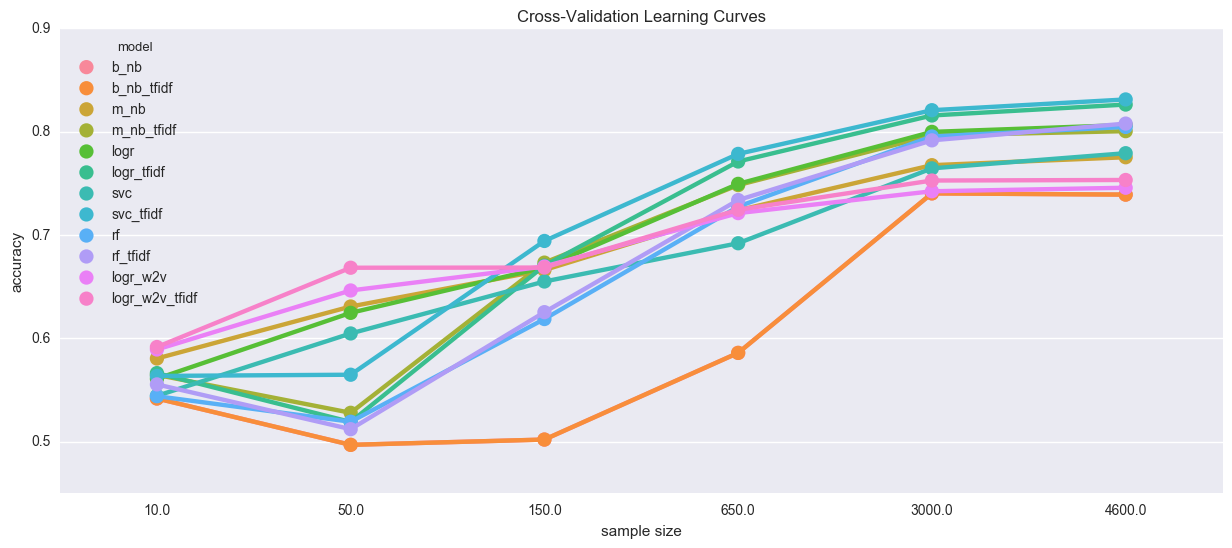

In [13]:
plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='sample', y='accuracy', hue='model', 
                    data=model_df[model_df.model.map(lambda x: x in model_names)])

fig.set(ylabel="accuracy")
fig.set(xlabel="sample size")
fig.set(title="Cross-Validation Learning Curves")

*Prior to ~150 documents, the word2vec vectorizer logistic regression performs best; however, somewhere around ~150, the trend reverses and the linear SVM starts to outperform all other models.*

## Haplaxes

In [6]:
#select a different column for X this time
X = df[(df['party'] != 'unavailable') & (df['protocol'] == False)]['text_stemmatized_haplatized']
y = df[(df['party'] != 'unavailable') & (df['protocol'] == False)]['party']
X, X_test, y, y_test = train_test_split(X,y,test_size = 0.1, random_state=1) 

*SVM with a linear kernal performed significantly better than any other alternative*

In [9]:
#due to the fact that SVC with a linear kernal performed better, we'll try LinearSVC for further optimization
svl_tfidf = Pipeline([("tfidf vectorizer", TfidfVectorizer(analyzer=lambda x: x)),
                      ("fast linear svc", LinearSVC())])

In [17]:
#only run the top models
models = [("svl_tfidf", svl_tfidf),
            ("logr_tfidf", logr_tfidf),
            ("svc_tfidf", svc_tfidf)]

scores = sorted([(name, cross_val_score(model, X, y, cv=5).mean()) 
                 for name, model in models], 
                key=lambda x: -x[1])
print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

model         score
----------  -------
svl_tfidf    0.8342
svc_tfidf    0.8319
logr_tfidf   0.8283


*Removing haplaxes gives us a very slight lift in cross-validated accuracy. In addtion, LinearSVC gives better results*

## Tuning

In [7]:
tv = TfidfVectorizer(analyzer=lambda x: x)  
X_vec = tv.fit_transform(X)
X_vec_test= tv.transform(X_test)

In [9]:
svm_grid = {'penalty': ['l2'],
            'C': [.1,.5,1,10], #default is 1
            'loss':['squared_hinge'],
            'dual':[True,False],
            'random_state': [1]}

In [10]:
svm_gridsearch = GridSearchCV(LinearSVC(),
                             svm_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='accuracy',
                             cv=5)
svm_gridsearch.fit(X_vec, y)

print("best parameters:", svm_gridsearch.best_params_)

best_model = svm_gridsearch.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   24.5s finished


best parameters: {'loss': 'squared_hinge', 'random_state': 1, 'dual': True, 'C': 1, 'penalty': 'l2'}


In [11]:
acc = np.mean(cross_val_score(best_model, X_vec, y, scoring='accuracy', cv = 5))
print("Cross-validated accurcy for tuned LinearSVC is {}".format(acc))

Cross-validated accurcy for tuned LinearSVC is 0.8347597179679542


*We get an extremely low lift in accuracy from simply setting 'dual' to True*

## Evaluation

In [12]:
best_model.fit(X_vec,y)
y_hat = best_model.predict(X_vec_test)
print("Test set accuracy for tuned model is:{}".format(accuracy_score(y_test,y_hat)))

Test set accuracy for tuned model is:0.8266871165644172


> *There is some evidence to suggest that the model has over-fit to the training data (as SVM has a tendency to do). More evidence that Logistic Regression might have been a more robust choice*

In [13]:
confusion_matrix(y_test, y_hat)

array([[265,  57],
       [ 56, 274]])

> *265 true negatives (true democrats), 274 true positives (true republicans), 57 false positives (false republicans), and 56 false negatives (false democrats)*

In [14]:
print("percent of dems correctly classified {} (Recall)".format(265/(57+265)))
print("percent of repubs correctly classified {} (Recall)".format(274/(56+274)))

percent of dems correctly classified 0.8229813664596274 (Recall)
percent of repubs correctly classified 0.8303030303030303 (Recall)


> *Our model has a slightly easier time (for Recall) classifying Republicans , but it is within the margin of error*

In [15]:
print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

        (D)       0.83      0.82      0.82       322
        (R)       0.83      0.83      0.83       330

avg / total       0.83      0.83      0.83       652



> *One our algorithm makes a classification, the precision/quality of that classification by class is essentially identical (83%), but in terms of recall, there's slightly better performance for Republicans as discussed above, but the difference is extremely close.*

In [18]:
continuous_yhat = best_model.decision_function(X_vec_test)

In [21]:
fpr, tpr, thresholds = roc_curve([1 if x == '(R)' else 0 for x in y_test],continuous_yhat)

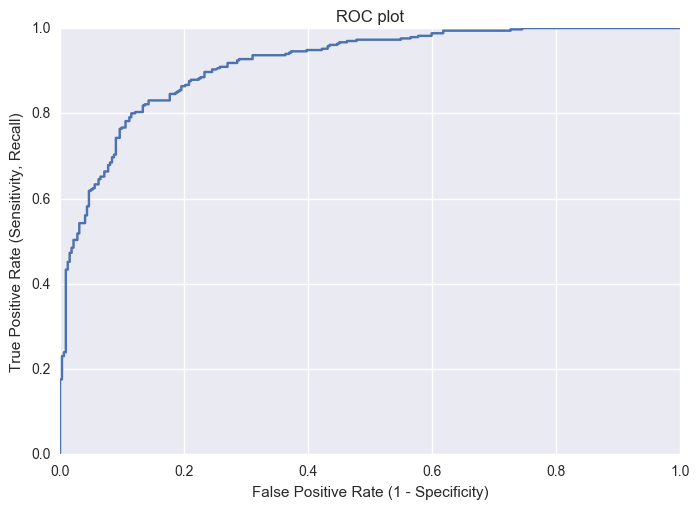

In [22]:
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot")
plt.show()

## Feature Selection

In [79]:
#according to http://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights
#we can use this to estimate feature importance
best_model.coef_[0]

array([ 0.03877903, -0.55565032,  0.06224192, ..., -0.29426556,
       -0.0447465 ,  0.38088694])

In [89]:
#zip(tv.get_feature_names(),best_model.coef_[0])
dem_words = sorted(zip(tv.get_feature_names(),best_model.coef_[0]), 
        key=lambda x: x[1])[0:30]
print(tabulate(dem_words, floatfmt=".4f", headers=("Stem", 'Coefficient')))

Stem           Coefficient
-----------  -------------
bush               -2.1906
republican         -2.1244
connecticut        -2.0385
san                -1.9384
african            -1.8454
compromis          -1.7501
western            -1.7419
rhode              -1.7100
hawaii             -1.6922
specul             -1.6898
invest             -1.6690
island             -1.6321
york               -1.6243
clean              -1.5713
loan               -1.5538
rise               -1.5368
public             -1.5305
smart              -1.5174
credit             -1.5017
delawar            -1.4775
class              -1.4744
st                 -1.4634
senior             -1.4477
postal             -1.4438
turkey             -1.4236
expir              -1.4222
se                 -1.4068
hr1161             -1.3359
pentagon           -1.3247
mortgag            -1.3042


In [90]:
rep_words = sorted(zip(tv.get_feature_names(),best_model.coef_[0]), 
        key=lambda x: -x[1])[0:30]
print(tabulate(rep_words, floatfmt=".4f", headers=("Stem", 'Coefficient')))

Stem          Coefficient
----------  -------------
illinoi            2.3958
arkansa            2.1655
speaker            1.9828
creator            1.9636
kansa              1.8845
mississi           1.8524
bless              1.7456
govern             1.6829
administr          1.6768
senat              1.6182
obamacar           1.6093
media              1.5749
grow               1.5624
dakota             1.5429
is                 1.5312
white              1.5108
south              1.4798
penn               1.4759
virginia           1.4618
desk               1.4539
individu           1.4425
regul              1.3924
hr1380             1.3762
bureaucrat         1.3756
patient            1.3735
rept               1.3719
relat              1.3426
russia             1.3097
enemi              1.3088
spend              1.3066


> *It is perhaps once more unremarkable that our model most heavily relies on state references to learn whether the representative is republican or democrat*

*For extra reference, HR138 was a bill that gave tax credits for natural gas and HR1161 reaffirmed that states had the power to regulate alcohol*

---

# Appendix
---

> Inititally I thought more features would improve the model; however, I found that there was essentially no lift from adding these features. This is why I moved this section to the Appendix. It is, however, useful to include this for reference on how to use Pipelines to combine vectorized and non-vectorized features into a single model

## More Features

*We can add sentiment from TextBlob, which returns both polarity as well as subjectivity. Also, we will add the word count, captured by length. *

In [67]:
def get_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [74]:
def get_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

In [70]:
df['polarity'] = df.apply(lambda row: get_polarity(row['text']), axis=1)
df['subjectivity'] = df.apply(lambda row: get_subjectivity(row['text']), axis=1)

In [77]:
#select more columsn for X this time
X = df[(df['party'] != 'unavailable') & (df['protocol'] == False)][['text_stemmatized_haplatized','length','polarity','subjectivity']]
y = df[(df['party'] != 'unavailable') & (df['protocol'] == False)]['party']
X, X_test, y, y_test = train_test_split(X,y,test_size = 0.1, random_state=1) 

In [45]:
#this class will allows us to use FeatureUnion in the Pipeline to create a matrix that combines both the vectorized
#TFIDF matrix with other features such as polarity:
class ItemSelector(BaseEstimator, TransformerMixin):
    """Given dataframe, selects columsn by key for specific selections
    http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [83]:
#build the pipeline
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            ('text', Pipeline([
                ('selector', ItemSelector(key='text_stemmatized_haplatized')),
                ('tfidf', TfidfVectorizer(analyzer=lambda x: x)) #we only vectorize the text
            ])),

            ('length', Pipeline([ #we don't need to vectorize these
                ('selector', ItemSelector(key=['length','polarity','subjectivity']))
            ]))

        ],

    )),

    ('lgr', LogisticRegression()),
])


In [87]:
np.mean(cross_val_score(pipeline, X, y, cv=5))

0.8282785648843628

> *This cross-validation error compares to the .8283 we had for Logisitic Regression TFIDF without these added features. It is unlikely that our two new features add value to our model*

In [89]:
pipeline.fit(X, y)
yhat = pipeline.predict(X_test)
print(classification_report(y_test, yhat))
print(accuracy_score(y_test, yhat))

             precision    recall  f1-score   support

        (D)       0.83      0.79      0.81       322
        (R)       0.80      0.85      0.82       330

avg / total       0.82      0.82      0.82       652

0.815950920245


In [91]:
confusion_matrix(y_test, yhat)

array([[253,  69],
       [ 51, 279]])

*Although this model does better in returning Republicans (85% Recall), it does so at the expense of Democrat Recall. In addition, it's Republican precision is lower than our best model. *